# **Enron Investigation Project**
### Enron Corporation, an energy, commodities, and services company infamously went bankrupt in December 2001 as a result of fraudulent business practices.
### The Federal Energy Regulatory Commission released more 1.6 million emails sent and received by Enron executives in the years from 2000–2002. 
### We use the metadata of these mails which contains information such as number received by and sent from each individual, and financial information including salary and stock options to identify the POI (Person of Interest). The persons of interest are the individuals who were eventually tried for fraud or criminal activity in the Enron investigation.
### The ultimate objective of investigating the Enron dataset is to be able to predict cases of fraud or unsafe business practices far in advance, so those responsible can be punished, and those who are innocent are not harmed.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

original = "final_project_dataset.pkl"
destination = "final_project_dataset_unix.pkl"

content = ''
outsize = 0
with open(original, 'rb') as infile:
    content = infile.read()
with open(destination, 'wb') as output:
    for line in content.splitlines():
        outsize += len(line) + 1
        output.write(line + str.encode('\n'))
        
data_dict = pickle.load(open("final_project_dataset_unix.pkl", "rb"))

payment_data = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments']
stock_data = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
email_data = ['to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']
features_list = ['poi'] + payment_data + stock_data + email_data

## **Outlier Investigation and Data Cleaning**
### The first step is to load in the all the data and scrutinize it for any errors that need to be corrected and outliers that should be removed. The data is provided in the form of a Python dictionary with each individual as a key and the information about the individual as values, and I will convert it to a pandas dataframe for easier data manipulation.

In [2]:
# Dataset
df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.sort_index(axis=0)
df.drop(['email_address'], axis=1, inplace=True)
df = df[['poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'to_messages', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi']]
df.head()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
ALLEN PHILLIP K,False,201955,4175000,304805,-3081055,2869717,NaN,152,13868,NaN,4484442,1729541,126027,-126027,1729541,2902,2195,47,65,1407
BADUM JAMES P,False,NaN,NaN,NaN,NaN,178980,NaN,NaN,3486,NaN,182466,257817,NaN,NaN,257817,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,False,477,NaN,NaN,-5104,NaN,NaN,864523,56301,NaN,916197,4046157,1757552,-560222,5243487,566,29,39,0,465
BAXTER JOHN C,False,267102,1200000,1586055,-1386055,1295738,NaN,2660303,11200,NaN,5634343,6680544,3942714,NaN,10623258,NaN,NaN,NaN,NaN,NaN
BAY FRANKLIN R,False,239671,400000,NaN,-201641,260455,NaN,69,129142,NaN,827696,NaN,145796,-82782,63014,NaN,NaN,NaN,NaN,NaN


In [3]:
# Dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   poi                        146 non-null    bool  
 1   salary                     146 non-null    object
 2   bonus                      146 non-null    object
 3   long_term_incentive        146 non-null    object
 4   deferred_income            146 non-null    object
 5   deferral_payments          146 non-null    object
 6   loan_advances              146 non-null    object
 7   other                      146 non-null    object
 8   expenses                   146 non-null    object
 9   director_fees              146 non-null    object
 10  total_payments             146 non-null    object
 11  exercised_stock_options    146 non-null    object
 12  restricted_stock           146 non-null    object
 13  restricted_stock_deferred  146 non-null    object


In [4]:
# Convert object datatype to float datatype
for i in df.columns:
  if df[i].dtypes == 'object':
    df[i] = pd.to_numeric(df[i],errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   poi                        146 non-null    bool   
 1   salary                     95 non-null     float64
 2   bonus                      82 non-null     float64
 3   long_term_incentive        66 non-null     float64
 4   deferred_income            49 non-null     float64
 5   deferral_payments          39 non-null     float64
 6   loan_advances              4 non-null      float64
 7   other                      93 non-null     float64
 8   expenses                   95 non-null     float64
 9   director_fees              17 non-null     float64
 10  total_payments             125 non-null    float64
 11  exercised_stock_options    102 non-null    float64
 12  restricted_stock           110 non-null    float64
 13  restricted_stock_deferred  18 non-n

In [5]:
# Dataframe statistics
df.describe()

,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
count,9.500000e+01,8.200000e+01,6.600000e+01,4.900000e+01,3.900000e+01,4.000000e+00,9.300000e+01,9.500000e+01,1.700000e+01,1.250000e+02,1.020000e+02,1.100000e+02,1.800000e+01,1.260000e+02,86.000000,86.000000,86.000000,86.000000,86.000000
mean,5.621943e+05,2.374235e+06,1.470361e+06,-1.140475e+06,1.642674e+06,4.196250e+07,9.190650e+05,1.087289e+05,1.668049e+05,5.081526e+06,5.987054e+06,2.321741e+06,1.664106e+05,6.773957e+06,2073.860465,608.790698,64.895349,41.232558,1176.465116
std,2.716369e+06,1.071333e+07,5.942759e+06,4.025406e+06,5.161930e+06,4.708321e+07,4.589253e+06,5.335348e+05,3.198914e+05,2.906172e+07,3.106201e+07,1.251828e+07,4.201494e+06,3.895777e+07,2582.700981,1841.033949,86.979244,100.073111,1178.317641
min,4.770000e+02,7.000000e+04,6.922300e+04,-2.799289e+07,-1.025000e+05,4.000000e+05,2.000000e+00,1.480000e+02,3.285000e+03,1.480000e+02,3.285000e+03,-2.604490e+06,-7.576788e+06,-4.409300e+04,57.000000,12.000000,0.000000,0.000000,2.000000
25%,2.118160e+05,4.312500e+05,2.812500e+05,-6.948620e+05,8.157300e+04,1.600000e+06,1.215000e+03,2.261400e+04,9.878400e+04,3.944750e+05,5.278862e+05,2.540180e+05,-3.896218e+05,4.945102e+05,541.250000,22.750000,10.000000,1.000000,249.750000
50%,2.599960e+05,7.693750e+05,4.420350e+05,-1.597920e+05,2.274490e+05,4.176250e+07,5.238200e+04,4.695000e+04,1.085790e+05,1.101393e+06,1.310814e+06,4.517400e+05,-1.469750e+05,1.102872e+06,1211.000000,41.000000,35.000000,8.000000,740.500000
75%,3.121170e+05,1.200000e+06,9.386720e+05,-3.834600e+04,1.002672e+06,8.212500e+07,3.620960e+05,7.995250e+04,1.137840e+05,2.093263e+06,2.547724e+06,1.002370e+06,-7.500975e+04,2.949847e+06,2634.750000,145.500000,72.250000,24.750000,1888.250000
max,2.670423e+07,9.734362e+07,4.852193e+07,-8.330000e+02,3.208340e+07,8.392500e+07,4.266759e+07,5.235198e+06,1.398517e+06,3.098866e+08,3.117640e+08,1.303223e+08,1.545629e+07,4.345095e+08,15149.000000,14368.000000,528.000000,609.000000,5521.000000


### Some of the maximum values seem unreasonable such the total payments which is $309 million or the to messages at 15,000. Those could be valid values, but they look suspicious on a first pass through the information.
### There are numerous NaNs in both the email and financial fields. According to the official pdf documentation for the financial data, values of NaN represent 0. However, for the email data, NaNs are unknown information.
### Therefore, we will replace any financial data that is NaN with a 0 but will fill in the NaNs for the email data with the mean of the column grouped by person of interest.

In [6]:
# Eliminate null values
from sklearn.impute import SimpleImputer

# Fill in the NaN payment and stock values with zero 
df[payment_data] = df[payment_data].fillna(0)
df[stock_data] = df[stock_data].fillna(0)

# Fill in the NaN email data with the mean of column grouped by poi / non_poi
imp = SimpleImputer(missing_values=np.nan, strategy = 'mean')

df_poi = df[df['poi'] == True];
df_nonpoi = df[df['poi'] == False]

df_poi.loc[:, email_data] = imp.fit_transform(df_poi.loc[:,email_data]);
df_nonpoi.loc[:, email_data] = imp.fit_transform(df_nonpoi.loc[:,email_data]);
df = df_poi.append(df_nonpoi)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### A simple way to check for outliers/incorrect data is to add up all of the payment related columns for each person and check if that is equal to the total payment recorded for the individual.

In [7]:
errors = (df[df[payment_data[:-1]].sum(axis='columns') != df['total_payments']])
errors.head()

,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,total_payments,exercised_stock_options,restricted_stock,restricted_stock_deferred,total_stock_value,to_messages,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi
BELFER ROBERT,False,0.0,0.0,0.0,0.0,-102500.0,0.0,0.0,0.0,3285.0,102500.0,3285.0,0.0,44093.0,-44093.0,2007.111111,668.763889,58.5,36.277778,1058.527778
BHATNAGAR SANJAY,False,0.0,0.0,0.0,0.0,0.0,0.0,137864.0,0.0,137864.0,15456290.0,2604490.0,-2604490.0,15456290.0,0.0,523.000000,29.000000,0.0,1.000000,463.000000


### There are two individuals for which the sum of their payments does not add up to the recorded total payment. The errors appear to be caused by a misalignment of the columns; for Robert Belfer, the financial data has been shifted one column to the right, and for Sanjay Bhatnagar, the data has been shifted one column to the left.

In [8]:
# Retrieve the incorrect data for Belfer
belfer_financial = df.loc[['BELFER ROBERT'], (payment_data + stock_data)].squeeze().tolist()
# Delete the first element to shift left and add on a 0 to end as indicated in financial data
belfer_financial.pop(0)
belfer_financial.append(0)
# Reinsert corrected data
df.loc['BELFER ROBERT', 1:15] = belfer_financial

# Retrieve the incorrect data for Bhatnagar
bhatnagar_financial = df.loc[['BHATNAGAR SANJAY'], (payment_data + stock_data)].squeeze().tolist()
# Delete the last element to shift right and add on a 0 to beginning
bhatnagar_financial.pop(-1)
bhatnagar_financial = [0] + bhatnagar_financial
# Reinsert corrected data
df.loc['BHATNAGAR SANJAY', 1:15] = bhatnagar_financial

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  from ipykernel import kernelapp as app


In [9]:
# Check for any more errors with the payment data
errors = (df[df[payment_data[:-1]].sum(axis='columns') != df['total_payments']])
len(errors)

0

### The official financial PDF states that the total row is what was displaying the suspect maximum numbers in the summary of the dataframe. Likewise, there is a row for 'THE TRAVEL AGENCY IN THE PARK', which according to the documentation, was a company co-owned by Enron's former Chairman's sister and is clearly not an individual that should be included in the dataset.

In [10]:
# Drop rows
df.drop(axis=0, labels=['TOTAL','THE TRAVEL AGENCY IN THE PARK'], inplace=True)

### We now look for outlying data points recorded in the different fields. The official definition of a mild outlier is either below the (first quartile minus 1.5 times the Interquartile Range (IQR)) or above the (third quartile plus 1.5 times the IQR)

In [11]:
# Identify outliers
IQR = df.quantile(q=0.75) - df.quantile(q=0.25)
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
outliers = df[(df>(third_quartile + 1.5*IQR) ) | (df<(first_quartile - 1.5*IQR) )].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(15)

LAY KENNETH L         15
FREVERT MARK A        12
BELDEN TIMOTHY N       9
SKILLING JEFFREY K     9
BAXTER JOHN C          8
LAVORATO JOHN J        8
DELAINEY DAVID W       7
KEAN STEVEN J          7
HAEDICKE MARK E        7
WHALLEY LAWRENCE G     7
RICE KENNETH D         6
KITCHEN LOUISE         6
BECK SALLY W           5
ALLEN PHILLIP K        5
HANNON KEVIN P         5
dtype: int64

### An outlier for a person of interest could be a sign of fradulent activity, such as evidence that someone is laundering illicit funds through the company payroll or is paying an accomplice to remain silent about illegal activity.
### We decided to remove four people from the dataset. I believe these removals are justified primarily because none of these individuals were persons of interest.

In [12]:
# Remove the outlier individuals
df.drop(axis=0, labels=['FREVERT MARK A', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G', 'BAXTER JOHN C'], inplace=True)

# Find the number of poi and non poi now in the data
df['poi'].value_counts()

False    122
True      18
Name: poi, dtype: int64

### There are 18 persons of interest, comprising 12.9% of the individuals.

## **Initial Algorithm Training and Performance Metrics**
### The four algorithms we have selected for initial testing are Gaussian Naive Bayes (GaussianNB), DecisionTreeClassifier, Support Vector Classifier (SVC), and KMeans Clustering.
### Although accuracy would appear to be the obvious choice for evaluating the quality of a classifier, accuracy can be a crude measure at times, and is not suited for some datasets including the Enron one. For example, if a classifier were to guess that all of the samples in the cleaned dataset were not persons of interest, it would have an accuracy of 87.1%. However, this clearly would not satisfy the objective of this investigation which is to create a classifier that can identify persons of interest. Therefore, different metrics are needed to evaluate the classifiers to to gauge performance. The two selected for use in this project are Precision and Recall. We will also consider F1 Score, as it is a combination of both.

In [13]:
from sklearn.preprocessing import scale
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
import tester

# Scale the dataset and send it back to a dictionary
scaled_df = df.copy()
scaled_df.iloc[:,1:] = scale(scaled_df.iloc[:,1:])
my_dataset = scaled_df.to_dict(orient='index')

In [14]:
# Create and test the Gaussian Naive Bayes Classifier
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

	Accuracy: 0.70714	Precision: 0.30909	Recall: 0.85000		F1: 0.45333	F2: 0.62963
	Total predictions:  140	True positives:   17	False positives:   38	False negatives:    3	True negatives:   82



In [15]:
# Create and test the Decision Tree Classifier
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.84286	Precision: 0.45000	Recall: 0.45000		F1: 0.45000	F2: 0.45000
	Total predictions:  140	True positives:    9	False positives:   11	False negatives:   11	True negatives:  109



In [16]:
# Create and test the Support Vector Machine Classifier
clf = SVC(kernel='linear')
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.86429	Precision: 0.57143	Recall: 0.20000		F1: 0.29630	F2: 0.22989
	Total predictions:  140	True positives:    4	False positives:    3	False negatives:   16	True negatives:  117



In [17]:
# Create and test the K-Means Classifier
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.70714	Precision: 0.11111	Recall: 0.15000		F1: 0.12766	F2: 0.14019
	Total predictions:  140	True positives:    3	False positives:   24	False negatives:   17	True negatives:   96



### We can see that gaussian naive bayes, decision tree and k-means clustering performed well enough to meet the standards for the project.
### Cross Validation: Cross-validation performs multiple splits on the dataset and in each split, forms a different training and testing set. Each iteration, the classifier is fit on a training set and then tested on a testing set.
### The tester.py script uses the StratifiedShuffleSplit cross-validation method, and GridSearchCV, which is used to find the optimal number of features and the best parameters, employs cross validation with the StratifiedKFolds cross-validator. In both cases, the dataset is split 10 times into training and testing sets.

## **Feature Engineering**
### The next step is to create new features from the existing information that could possibly improve performance. We will also need to carry out feature selection to remove those features that are not useful for predicting a person of interest.
### We decided on three new features to create from the email metadata. The first will be the ratio of emails to an individual from a person of interest to all emails addressed to that person, the second is the same but for messages to persons of interest, and the third will be the ratio of email receipts shared with a person of interest to all emails addressed to that individual. The reason for this choice is that a relative number matters more as compared to an absolute number

In [18]:
# Add the new email features to the dataframe
df['to_poi_ratio'] = df['from_poi_to_this_person'] / df['to_messages']
df['from_poi_ratio'] = df['from_this_person_to_poi'] / df['from_messages']
df['shared_poi_ratio'] = df['shared_receipt_with_poi'] / df['to_messages']
features_list.append('to_poi_ratio')
features_list.append('from_poi_ratio')
features_list.append('shared_poi_ratio')

### We think that people recieving large bonuses may be more likely to be persons of interest becuase the bonuses could be a result of fraudulent activity. It would be easier to pass off illegal funds as a bonus rather than a salary raise. The two new features will be the bonus in relation to the salary, and the bonus in relation to total payments.

In [19]:
# Add the new financial features to the dataframe
df['bonus_to_salary'] = df['bonus'] / df['salary']
df['bonus_to_total'] = df['bonus'] / df['total_payments']  
features_list.append('bonus_to_salary')
features_list.append('bonus_to_total')  

### After adding in the features, we will again check for model performance.


In [20]:
# Fill any NaN financial data with a 0
df.fillna(value= 0, inplace=True)

# Scale the dataset and send it back to a dictionary
scaled_df = df.copy()
scaled_df.iloc[:,1:] = scale(scaled_df.iloc[:,1:])
my_dataset = scaled_df.to_dict(orient='index')

In [21]:
# Create and test the Gaussian Naive Bayes Classifier
clf = GaussianNB()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main();

	Accuracy: 0.72857	Precision: 0.32000	Recall: 0.80000		F1: 0.45714	F2: 0.61538
	Total predictions:  140	True positives:   16	False positives:   34	False negatives:    4	True negatives:   86



In [22]:
# Create and test the Decision Tree Classifier
clf = DecisionTreeClassifier()
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.92143	Precision: 0.73684	Recall: 0.70000		F1: 0.71795	F2: 0.70707
	Total predictions:  140	True positives:   14	False positives:    5	False negatives:    6	True negatives:  115



In [23]:
# Create and test the Support Vector Machine Classifier
clf = SVC(kernel='linear')
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.83571	Precision: 0.33333	Recall: 0.15000		F1: 0.20690	F2: 0.16854
	Total predictions:  140	True positives:    3	False positives:    6	False negatives:   17	True negatives:  114



In [24]:
# Create and test the K-Means Classifier
clf = KMeans(n_clusters=2)
tester.dump_classifier_and_data(clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.64286	Precision: 0.08333	Recall: 0.15000		F1: 0.10714	F2: 0.12931
	Total predictions:  140	True positives:    3	False positives:   33	False negatives:   17	True negatives:   87



### The F1 score for the decision tree is the highest followed by the Gaussian Naive Bayes Classifier. At this point, neither the SVC with the linear kernel nor the KMeans clustering perform well. We will drop the latter two algorithms and I will also include the AdaBoost Classifier because to experiment with tunable parameters.

## **Feature Visualization**

### The following is a simple scatterplot of the email ratio features we created and the bonus ratios we created.

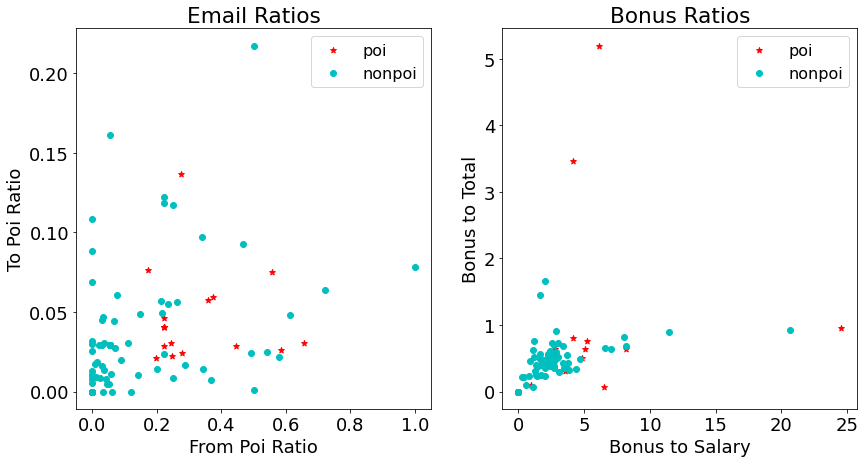

In [25]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

poi_df = df[df['poi']==True]
nonpoi_df = df[df['poi']==False]

plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
plt.scatter(x=poi_df['from_poi_ratio'], y = poi_df['to_poi_ratio'], color = 'red', marker='*')
plt.scatter(x=nonpoi_df['from_poi_ratio'], y = nonpoi_df['to_poi_ratio'], color = 'c')
plt.xlabel('From Poi Ratio'); plt.ylabel('To Poi Ratio'); plt.title('Email Ratios'); 
plt.legend(['poi', 'nonpoi'], prop= {'size': 16})

ax2 = fig.add_subplot(122)
plt.scatter(x=poi_df['bonus_to_salary'], y = poi_df['bonus_to_total'], color = 'red', marker='*')
plt.scatter(x=nonpoi_df['bonus_to_salary'], y = nonpoi_df['bonus_to_total'], color = 'c')
plt.xlabel('Bonus to Salary'); plt.ylabel('Bonus to Total'); plt.title('Bonus Ratios');
plt.legend(['poi', 'nonpoi'], prop= {'size': 16});

### In both plots, the non persons of interest are clustered to the bottom left, but there is not a clear trend among the persons of interest. 

### The plot below is a scatter matrix showing all the relationships between four selected features: ‘bonus’, ‘total_payments’, ‘to_poi_ratio’, and ‘from_poi_ratio’.

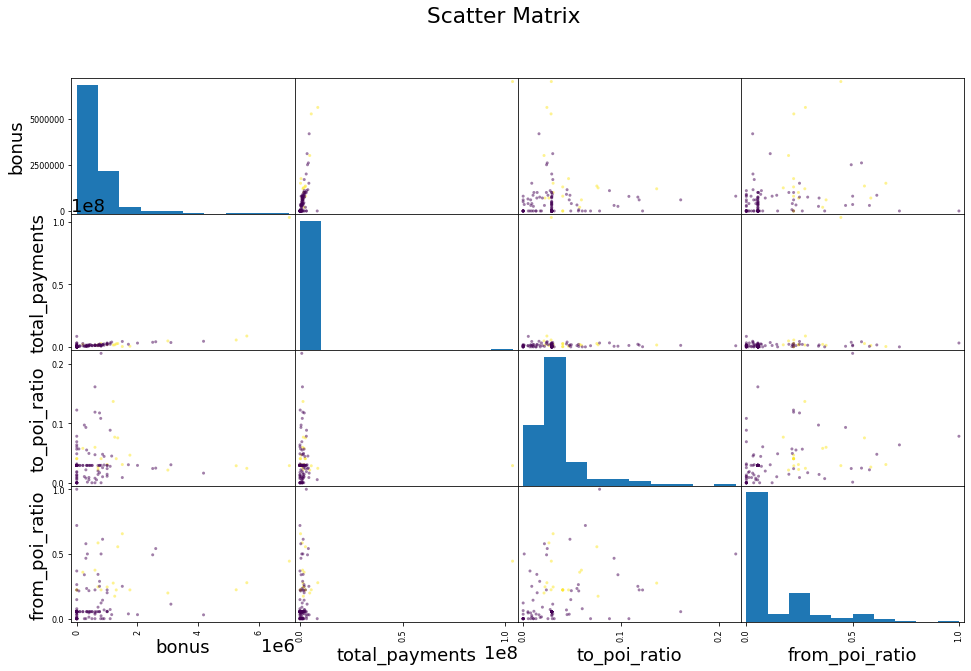

In [26]:
from pandas.plotting import scatter_matrix
features_to_plot = ['bonus',  'total_payments', 'to_poi_ratio', 'from_poi_ratio']
scatter_matrix(df[features_to_plot], figsize=(16,10), c=df['poi']);
plt.suptitle('Scatter Matrix');

### Looking at the bonus vs from_poi_ratio, the persons of interest tend to be further to the right and higher than non persons of interest. This indicates that persons of interest tend to recieve larger bonuses and they send more emails to other persons of interest.

## **Feature Selection**
### First, we will manually look at the feature importances for both classifiers to get a sense of which features are most important.

In [27]:
clf_tree = DecisionTreeClassifier()
clf_tree = tester.test_classifier(clf_tree, my_dataset, features_list)

	Accuracy: 0.90714	Precision: 0.68421	Recall: 0.65000		F1: 0.66667	F2: 0.65657
	Total predictions:  140	True positives:   13	False positives:    6	False negatives:    7	True negatives:  114



In [28]:
# Get the feature importances of the DecisionTree Classifier
tree_feature_importances = (clf_tree.feature_importances_)
tree_features = zip(tree_feature_importances, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)

# Display the feature names and importance values
print('Tree Feature Importances:\n')
for i in range(10):
    print('{} : {:.4f}'.format(tree_features[i][1], tree_features[i][0]))

Tree Feature Importances:

from_poi_ratio : 0.3782
shared_receipt_with_poi : 0.2485
expenses : 0.2397
from_poi_to_this_person : 0.0671
shared_poi_ratio : 0.0665
salary : 0.0000
bonus : 0.0000
long_term_incentive : 0.0000
deferred_income : 0.0000
deferral_payments : 0.0000


In [29]:
clf_ada = AdaBoostClassifier()
clf_ada = tester.test_classifier(clf_ada, my_dataset, features_list)

	Accuracy: 0.94286	Precision: 0.83333	Recall: 0.75000		F1: 0.78947	F2: 0.76531
	Total predictions:  140	True positives:   15	False positives:    3	False negatives:    5	True negatives:  117



In [30]:
# Get the feature importances for the AdaBoost Classifier
ada_feature_importances = clf_ada.feature_importances_
ada_features = zip(ada_feature_importances, features_list[1:])

# Display the feature names and importance values
print('Ada Boost Feature Importances:\n')
ada_features = sorted(ada_features, key=lambda x:x[0], reverse=True)
for i in range(10):
    print('{} : {:.4f}'.format(ada_features[i][1], ada_features[i][0]))

Ada Boost Feature Importances:

shared_receipt_with_poi : 0.1200
exercised_stock_options : 0.1000
from_this_person_to_poi : 0.1000
to_poi_ratio : 0.1000
deferred_income : 0.0800
from_messages : 0.0800
from_poi_ratio : 0.0800
other : 0.0600
total_stock_value : 0.0600
shared_poi_ratio : 0.0400


### It is interesting to compare the feature importances for the DecisionTree and the AdaBoost classifiers. The top 10 features are not in close agreement even though both classifiers achieve a respectable F1 Score greater than 0.5. However, rather than manually selecting the features to keep, we will use GridSearchCV with SelectKBest to find the optimal number of features for the classifiers. GridSearchCV runs through a parameter grid and tests all the different configurations provided to it. It returns the parameters that yield the maximum score. We will use a scoring parameter of F1 because that is what we would like to maximize, and a cross-validation with 10 splits to ensure that we are not overfitting the algorithm to the training data.

In [31]:
from feature_format import featureFormat, targetFeatureSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

data_dict = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data_dict)

In [32]:
from sklearn.model_selection import GridSearchCV

n_features = np.arange(1, len(features_list))

# Create a pipeline with feature selection and classification
pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', DecisionTreeClassifier())
])

param_grid = [
    {
        'select_features__k': n_features
    }
]

# Use GridSearchCV to automate the process of finding the optimal number of features
tree_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv = 10)
tree_clf.fit(features, labels);

In [33]:
tree_clf.best_params_

{'select_features__k': 20}

In [34]:
tree_selection = SelectKBest(k=20)
tree_selection.fit_transform(features, labels)

tree_scores = tree_selection.scores_
tree_features = zip(tree_scores, features_list[1:])
tree_features = sorted(tree_features, key= lambda x:x[0], reverse=True)

print('Tree Feature F-statistics:\n')
for i in range(20):
    print('{} : {:.4f}'.format(tree_features[i][1], tree_features[i][0]))

Tree Feature F-statistics:

bonus : 36.2022
from_poi_ratio : 25.8246
salary : 25.4609
total_stock_value : 24.8372
exercised_stock_options : 24.0888
bonus_to_total : 20.8908
deferred_income : 17.0963
bonus_to_salary : 17.0251
shared_poi_ratio : 16.1635
shared_receipt_with_poi : 14.7385
from_poi_to_this_person : 12.9213
long_term_incentive : 12.7397
total_payments : 10.2104
restricted_stock : 10.0832
other : 7.9157
loan_advances : 7.0635
expenses : 5.7008
from_this_person_to_poi : 3.4099
to_poi_ratio : 2.8564


### According to the grid search performed with SelectKBest with the number of features ranging from 1 to 24 (the number of features minus one), the optimal number of features for the decision tree classifier is 19.

In [35]:
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=20)),
    ('classify', DecisionTreeClassifier()),
])

tester.dump_classifier_and_data(tree_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.92143	Precision: 0.71429	Recall: 0.75000		F1: 0.73171	F2: 0.74257
	Total predictions:  140	True positives:   15	False positives:    6	False negatives:    5	True negatives:  114



### A similar procedure with GridSearchCV and SelectKBest will be carried out to determine the optimal number of features to use with the AdaBoostClassifier.

In [ ]:
n_features = np.arange(1, len(features_list))
# Create a pipeline of feature selection and classifier
pipe = Pipeline([
    ('select_features', SelectKBest()),
    ('classify', AdaBoostClassifier())
])

param_grid = [
    {
        'select_features__k': n_features
    }
]

# Use GridSearchCV to automate the process of finding the optimal number of features
ada_clf= GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv =10)
ada_clf.fit(features, labels)

In [37]:
ada_clf.best_params_

{'select_features__k': 20}

In [38]:
ada_selection = SelectKBest(k=20)
ada_selection.fit_transform(features, labels)

ada_scores = ada_selection.scores_
ada_features = zip(ada_scores, features_list[1:])
ada_features = sorted(ada_features, key= lambda x:x[0], reverse=True)

print('AdaBoost Features F-statistics:\n')
for i in range(20):
    print('{} : {:.4f}'.format(ada_features[i][1], ada_features[i][0]))

AdaBoost Features F-statistics:

bonus : 36.2022
from_poi_ratio : 25.8246
salary : 25.4609
total_stock_value : 24.8372
exercised_stock_options : 24.0888
bonus_to_total : 20.8908
deferred_income : 17.0963
bonus_to_salary : 17.0251
shared_poi_ratio : 16.1635
shared_receipt_with_poi : 14.7385
from_poi_to_this_person : 12.9213
long_term_incentive : 12.7397
total_payments : 10.2104
restricted_stock : 10.0832
other : 7.9157
loan_advances : 7.0635
expenses : 5.7008
from_this_person_to_poi : 3.4099
to_poi_ratio : 2.8564
director_fees : 2.1897


In [39]:
tester.dump_classifier_and_data(ada_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.92857	Precision: 0.77778	Recall: 0.70000		F1: 0.73684	F2: 0.71429
	Total predictions:  140	True positives:   14	False positives:    4	False negatives:    6	True negatives:  116



## **Hyperarameter Tuning**
### Parameter tuning is the process of optimizing the settings of a machine learning algorithm to achieve maximum performance on a given dataset. 
### The proces of parameter tuning can be automated by another algorithm such as GridSearchCV. A parameter grid is passed to GridSearchCV that consists of a number of combinations of parameters to test with an algorithm, and the search returns the parameters that maximize performance.

In [ ]:
# Create a pipeline with feature selection and classifier
tree_pipe = Pipeline([
    ('select_features', SelectKBest(k=19)),
    ('classify', DecisionTreeClassifier()),
])

# Define the configuration of parameters to test with the 
# Decision Tree Classifier
param_grid = dict(classify__criterion = ['gini', 'entropy'] , 
                  classify__min_samples_split = [2, 4, 6, 8, 10, 20],
                  classify__max_depth = [None, 5, 10, 15, 20],
                  classify__max_features = [None, 'sqrt', 'log2', 'auto'])

# Use GridSearchCV to find the optimal hyperparameters for the classifier
tree_clf = GridSearchCV(tree_pipe, param_grid = param_grid, scoring='f1', cv=10)
tree_clf.fit(features, labels)

In [41]:
# Get the best algorithm hyperparameters for the Decision Tree
tree_clf.best_params_

{'classify__criterion': 'entropy',
 'classify__max_depth': 5,
 'classify__max_features': None,
 'classify__min_samples_split': 20}

In [42]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV
tree_clf = Pipeline([
    ('select_features', SelectKBest(k=19)),
    ('classify', DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=None, min_samples_split=20))
])

# Test the classifier using tester.py
tester.dump_classifier_and_data(tree_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.97143	Precision: 0.86364	Recall: 0.95000		F1: 0.90476	F2: 0.93137
	Total predictions:  140	True positives:   19	False positives:    3	False negatives:    1	True negatives:  117



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create the pipeline with feature selection and AdaBoostClassifier
ada_pipe = Pipeline([('select_features', SelectKBest(k=20)),
                     ('classify', AdaBoostClassifier())
                    ])

# Define the parameter configurations to test with GridSearchCV
param_grid = dict(classify__base_estimator=[DecisionTreeClassifier(), RandomForestClassifier(), GaussianNB()],
                  classify__n_estimators = [30, 50, 70, 120],
                  classify__learning_rate = [0.5, 1, 1.5, 2, 4])

# Use GridSearchCV to automate the process of finding the optimal parameters
ada_clf = GridSearchCV(ada_pipe, param_grid=param_grid, scoring='f1', cv=10)
ada_clf.fit(features, labels)

In [44]:
# Display the best parameters for the AdaBoostClassifier
ada_clf.best_params_

{'classify__base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'classify__learning_rate': 1,
 'classify__n_estimators': 30}

In [45]:
# Create the classifier with the optimal hyperparameters as found by GridSearchCV
ada_clf = Pipeline([('select_features', SelectKBest(k=20)),
                   ('classify', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=1, n_estimators=30))
                   ])

# Test the classifier using tester.py
tester.dump_classifier_and_data(ada_clf, my_dataset, features_list)
tester.main()

	Accuracy: 0.91429	Precision: 0.70000	Recall: 0.70000		F1: 0.70000	F2: 0.70000
	Total predictions:  140	True positives:   14	False positives:    6	False negatives:    6	True negatives:  114



## **Conclusion**
### Based on these results, the final algorithm we chose was the DecisionTreeClassifier. My final model is composed of the Decision Tree algorithm, the 19 features from SelectKBest feature selection, and the model hyperparameters defined above.